# Bonus1: Parallel Algorithms

### Name: Amir Morcos


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.04147858 -0.09229019  0.02315271 -0.15105148 -0.17473772 -0.01607331
  -0.05133045  0.03527629]]
test std = 
[[1.02541657 0.89897433 0.90575598 0.99493777 0.7732082  1.0257021
  1.06016612 1.00706415]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


In [5]:
class Worker:
    def __init__(self,x,y,q=1, alpha = 1E-1, beta = 0.9, lam = 1E-6):
        self.x=x#s-by-d local feature matrix
        self.y=y#s-by-1 local label matrix
        self.s=x.shape[0]#number of local samples
        self.d=x.shape[1]#number of features
        self.w=numpy.zeros((self.d,1))#d-by-1 model parameter vector
        self.mw=numpy.zeros((self.d,1))#d-by-1 model parameter vector
        self.v=numpy.zeros((self.d,1))#d x 1 momentum
        
        #self.v=0#d x 1 momentum
        self.q = q
        self.alpha = alpha
        self.beta = beta
        
        
#Set the model parameters to the latest
    def set_param(self,w):
        self.w=w

#Compute the local loss
    def loss(self):
        yx=numpy.multiply(self.y,self.x)#s-by-d matrix
        yxw=numpy.dot(yx,self.mw)#s-by-1 matrix
        vec1=numpy.exp(-yxw)#s-by-1 matrix
        vec2=numpy.log(1+vec1)#s x 1 matrix
        return numpy.sum(vec2)#loss function

#Compute the local gradient
    def gradient(self):
        self.mw = numpy.copy(self.w)
        
        for f in range(self.q):
            
            yx=numpy.multiply(self.y,self.x)#s x d matrix
            yxw=numpy.dot(yx,self.mw)#s x1 matrix
            vec1=numpy.exp(yxw)#s x 1 matrix
            vec2=numpy.divide(yx,1+vec1)#s xd matrix
            g=-numpy.sum(vec2,axis=0).reshape(self.d,1)#d x 1 matrix

            lg=g/self.s+lam*self.mw
            self.v*=beta
            self.v+=lg
            self.mw-=alpha*self.v
            
        return g
    
#Compute the local gradient
    def stochastic_gradient(self):
        self.mw = numpy.copy(self.w)
        
        for f in range(self.q):
            rand_indices = numpy.random.permutation(self.s)
            x_rand = self.x[rand_indices, :]
            y_rand = self.y[rand_indices, :]
            
            for i in range(self.s):

                d = x_rand[i,:].shape[0]
                yx = float(y_rand[i,:]) * x_rand[i,:] # 1-by-d matrix
                yxw = float(numpy.dot(yx, self.mw)) # scalar
    
                # calculate objective function Q_i
                loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
                reg = lam / 2 * numpy.sum(self.mw * self.mw) # scalar
                obj = loss + reg
    
                # calculate stochastic gradient
                g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
                g = g_loss + lam * self.mw # d-by-1 matrix                
              
                self.mw-=alpha*g
            
        return g    

In [6]:
class Server:
    def __init__(self,m,n,d):
        self.m=m #number of workernodes
        self.n=n #number of training samples
        self.d=d #number of features
        self.w=numpy.zeros((d,1))#d x 1 model parameter vector
        self.g=numpy.zeros((d,1))#d x 1 gradient
        self.v=numpy.zeros((d,1))#d x 1 momentum
        self.loss=0 #loss function value
        self.obj=0 #objective function value

    def broadcast(self):
        return self.w

    #Sum the gradients and loss function evaluated by the workers
    #Args:
    #grads:a list of d x 1 vectors
    #losses:a list of scalars
    def aggregate(self,grads,losses):
        self.g=numpy.zeros((self.d,1))
        self.loss=0
        for k in range(self.m):
            self.g+=grads[k]
            self.loss+=losses[k]

    #Compute the gradient (from the loss and regularization)
    def gradient(self,lam):
        self.g=self.g/self.n+lam*self.w

    #Compute the objective function (sum of loss and regularization)
    def objective(self,lam):
        reg=lam/2*numpy.sum(self.w*self.w)
        self.obj=self.loss/self.n+reg
        return self.obj

    #Update the model parameters using accelerated gradient descent
    #Args:
    #alpha:learning rate(stepsize)
    #beta:momentum parameter
    def agd(self,alpha,beta):
        self.v*=beta
        self.v+=self.g
        self.w-=alpha*self.v


In [7]:
import math

#Create a server and m worker nodes
def create_server_workers(m,x,y,q):
    n,d=x.shape
    s=math.floor(n/m)
    server=Server(m,n,d)
    workers=[]

    for i in range(m):
        indices=list(range(i*s,(i+1)*s))
        worker=Worker(x[indices,:],y[indices,:],q)
        workers.append(worker)

    return server, workers

In [8]:
m=4 #number of worker nodes
server,workers=create_server_workers(m,x_train,y_train,1)

lam=1E-6 #regularization parameter
alpha=1E-1 #learning rate
beta=0.9 #momentum parameter
max_epoch=50 #number of epochs
PAGD = []
for t in range(max_epoch):
#step1:broadcast
    w=server.broadcast()
    for i in range(m):
        workers[i].set_param(w)

    #step2:workers'localcomputations
    grads=[]
    losses=[]
    for i in range(m):
        g=workers[i].gradient()
        grads.append(g)
        l=workers[i].loss()
        losses.append(l)

    #step3:aggregate the workers' outputs
    server.aggregate(grads,losses)

    #step4:server update the model parameters
    server.gradient(lam)#computegradient
    obj=server.objective(lam)#compute objective function
    print('Objectivefunctionvalue='+str(obj))
    PAGD.append(obj)
    server.agd(alpha,beta)#updates the model parameters


Objectivefunctionvalue=0.680749530318369
Objectivefunctionvalue=0.6594348151230527
Objectivefunctionvalue=0.6330527626715956
Objectivefunctionvalue=0.6053751153934757
Objectivefunctionvalue=0.579362686476482
Objectivefunctionvalue=0.556810778334718
Objectivefunctionvalue=0.5384083394511333
Objectivefunctionvalue=0.5240491817258921
Objectivefunctionvalue=0.5131891394166502
Objectivefunctionvalue=0.50512607732394
Objectivefunctionvalue=0.4991728653144099
Objectivefunctionvalue=0.4947423801832935
Objectivefunctionvalue=0.4913753006543851
Objectivefunctionvalue=0.48873640035569077
Objectivefunctionvalue=0.48659634174395616
Objectivefunctionvalue=0.4848087726285749
Objectivefunctionvalue=0.48328779739852434
Objectivefunctionvalue=0.48198815760041813
Objectivefunctionvalue=0.4808890021889851
Objectivefunctionvalue=0.479981401322675
Objectivefunctionvalue=0.47925940602107203
Objectivefunctionvalue=0.478714282253931
Objectivefunctionvalue=0.47833145526838355
Objectivefunctionvalue=0.4780896481

In [9]:
m=4 #number of worker nodes
server,workers=create_server_workers(m,x_train,y_train,1)

lam=1E-6 #regularization parameter
alpha=1E-1 #learning rate
beta=0.9 #momentum parameter
max_epoch=50 #number of epochs
PASGD = []
for t in range(max_epoch):
#step1:broadcast
    w=server.broadcast()
    for i in range(m):
        workers[i].set_param(w)

    #step2:workers'localcomputations
    grads=[]
    losses=[]
    for i in range(m):
        g=workers[i].stochastic_gradient()
        grads.append(g)
        l=workers[i].loss()
        losses.append(l)

    #step3:aggregate the workers' outputs
    server.aggregate(grads,losses)

    #step4:server update the model parameters
    server.gradient(lam)#computegradient
    obj=server.objective(lam)#compute objective function
    print('Objectivefunctionvalue='+str(obj))
    PASGD.append(obj)
    server.agd(alpha,beta)#updates the model parameters


Objectivefunctionvalue=0.4888354162897716
Objectivefunctionvalue=0.5074084893260326
Objectivefunctionvalue=0.4957643645577855
Objectivefunctionvalue=0.4791947276206161
Objectivefunctionvalue=0.49508862713784585
Objectivefunctionvalue=0.47911581809318465
Objectivefunctionvalue=0.49273756927422835
Objectivefunctionvalue=0.48633425632971716
Objectivefunctionvalue=0.4891285928175696
Objectivefunctionvalue=0.5043441642798752
Objectivefunctionvalue=0.49475320622166724
Objectivefunctionvalue=0.4882727089521558
Objectivefunctionvalue=0.4889437724801343
Objectivefunctionvalue=0.4868454366379673
Objectivefunctionvalue=0.4921262792311842
Objectivefunctionvalue=0.4854097780589617
Objectivefunctionvalue=0.4952245142444949
Objectivefunctionvalue=0.49255866223292516
Objectivefunctionvalue=0.49148740112926653
Objectivefunctionvalue=0.4943202764057566
Objectivefunctionvalue=0.4883604992623467
Objectivefunctionvalue=0.5020121198188109
Objectivefunctionvalue=0.5030607006890732
Objectivefunctionvalue=0.48

In [10]:
m=4 #number of worker nodes
server,workers=create_server_workers(m,x_train,y_train,8)
FDAFG = []
for t in range(max_epoch):
#step1:broadcast
    w=server.broadcast()
    for i in range(m):
        workers[i].set_param(w)

    #step2:workers'localcomputations
    grads=[]
    losses=[]
    for i in range(m):
        g=workers[i].gradient()
        grads.append(g)
        l=workers[i].loss()
        losses.append(l)

    #step3:aggregate the workers' outputs
    server.aggregate(grads,losses)

    #step4:server update the model parameters
    server.gradient(lam)#computegradient
    obj=server.objective(lam)#compute objective function
    print('Objectivefunctionvalue='+str(obj))
    FDAFG.append(obj)
    server.agd(alpha,beta)#updates the model parameters


Objectivefunctionvalue=0.52036640452129
Objectivefunctionvalue=0.4879822118811435
Objectivefunctionvalue=0.48244257175397126
Objectivefunctionvalue=0.48135279391955904
Objectivefunctionvalue=0.48082132539311717
Objectivefunctionvalue=0.4804659769980019
Objectivefunctionvalue=0.4801554015352415
Objectivefunctionvalue=0.47986439062067104
Objectivefunctionvalue=0.4795866375986806
Objectivefunctionvalue=0.4793216542080019
Objectivefunctionvalue=0.4790701299724862
Objectivefunctionvalue=0.4788329665296855
Objectivefunctionvalue=0.4786109914348169
Objectivefunctionvalue=0.478404907077249
Objectivefunctionvalue=0.4782152939815108
Objectivefunctionvalue=0.4780426285964659
Objectivefunctionvalue=0.4778873007243563
Objectivefunctionvalue=0.4777496260867577
Objectivefunctionvalue=0.47762985268244845
Objectivefunctionvalue=0.4775281611532318
Objectivefunctionvalue=0.47744466017594767
Objectivefunctionvalue=0.4773793783216474
Objectivefunctionvalue=0.477332253978028
Objectivefunctionvalue=0.4773031

In [11]:
m=4 #number of worker nodes
server,workers=create_server_workers(m,x_train,y_train,8)
FDAFSG = []
for t in range(max_epoch):
#step1:broadcast
    w=server.broadcast()
    for i in range(m):
        workers[i].set_param(w)

    #step2:workers'localcomputations
    grads=[]
    losses=[]
    for i in range(m):
        g=workers[i].stochastic_gradient()
        grads.append(g)
        l=workers[i].loss()
        losses.append(l)

    #step3:aggregate the workers' outputs
    server.aggregate(grads,losses)

    #step4:server update the model parameters
    server.gradient(lam)#computegradient
    obj=server.objective(lam)#compute objective function
    print('Objectivefunctionvalue='+str(obj))
    FDAFSG.append(obj)
    server.agd(alpha,beta)#updates the model parameters


Objectivefunctionvalue=0.47990133040015126
Objectivefunctionvalue=0.4767008473376192
Objectivefunctionvalue=0.487729415285682
Objectivefunctionvalue=0.4784205589159534
Objectivefunctionvalue=0.4846948887293579
Objectivefunctionvalue=0.47338002358957443
Objectivefunctionvalue=0.47807910675900117
Objectivefunctionvalue=0.48695644554720985
Objectivefunctionvalue=0.47521558288871946
Objectivefunctionvalue=0.4862755130109634
Objectivefunctionvalue=0.47731816500867613
Objectivefunctionvalue=0.4930952234178746
Objectivefunctionvalue=0.4842216802936155
Objectivefunctionvalue=0.47577051196789716
Objectivefunctionvalue=0.48042175145276395
Objectivefunctionvalue=0.4925561332752885
Objectivefunctionvalue=0.4816189324291954
Objectivefunctionvalue=0.481123263674912
Objectivefunctionvalue=0.4930100242998498
Objectivefunctionvalue=0.48068583191517333
Objectivefunctionvalue=0.48846954718785207
Objectivefunctionvalue=0.4851595098685691
Objectivefunctionvalue=0.488842798857323
Objectivefunctionvalue=0.47

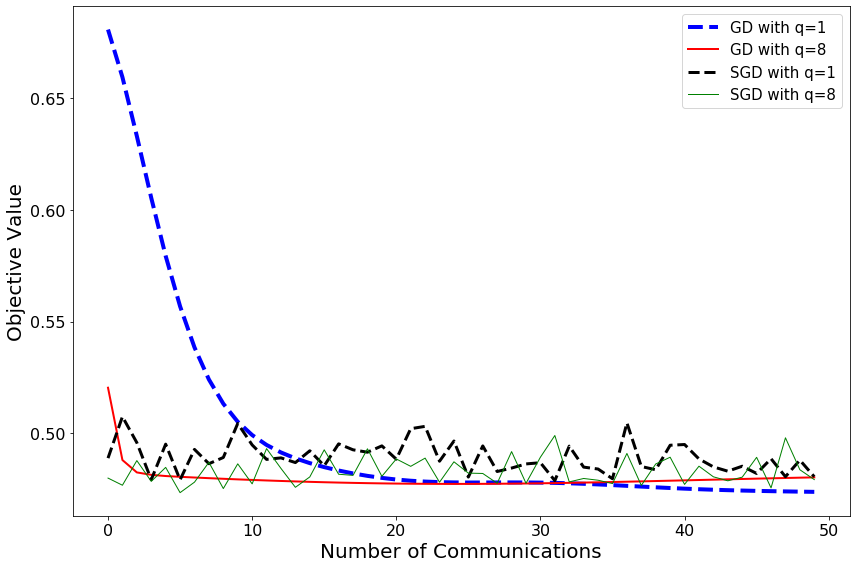

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the 4 curves:
fig = plt.figure(figsize=(12, 8))

Comm_PAGD = range(len(PAGD))
Comm_FDAFG = range(len(FDAFG))
Comm_PASGD = range(len(PASGD))
Comm_FDAFSG = range(len(FDAFSG))


line0, = plt.plot(Comm_PAGD, PAGD, '--b', LineWidth=4)
line1, = plt.plot(Comm_FDAFG, FDAFG, '-r', LineWidth=2)
line2, = plt.plot(Comm_PASGD, PASGD, '--k', LineWidth=3)
line3, = plt.plot(Comm_FDAFSG, FDAFSG, '-g', LineWidth=1)

plt.xlabel('Number of Communications', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)


plt.legend([line0, line1,line2, line3], ['GD with q=1', 'GD with q=8', 'SGD with q=1','SGD with q=8'], fontsize=15)
plt.tight_layout()
plt.show()
fig.savefig('compare_PAGD_FD_AGD.pdf', format='pdf', dpi=1200)